### Face mask detection classifier
I'm building a face mask classifier, which can be used to detect if a person is wearing a face mask or not.<br>
The dataset used is gotten from <a href="https://www.kaggle.com/datasets/andrewmvd/face-mask-detection">kaggle</a>

#### Import libraries

In [1]:
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET # Is used to parse an xml annotatin format
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import pandas as pd
import numpy as np
import glob
import os
import cv2

#### Setup paths

In [2]:
image_path = r"C:\Users\pc\Desktop\Machine_learning\face_mask\Face_mask\images"
annotation_path = r"C:\Users\pc\Desktop\Machine_learning\face_mask\Face_mask\annotations"
model_path = r"C:\Users\pc\Desktop\Machine_learning\face_mask\Face_mask\models" # it contains opencv caffe model which is used to detect face
workspace = r"C:\Users\pc\Desktop\Machine_learning\face_mask\Face_mask"
images = os.listdir(image_path) # import image name as list
print('Number of images is', len(images))

Number of images is 855


#### Read the annototions in .xml format into a dataframe

In [3]:
# Create a function to pass annotation

def parse_annotation(path):
    tree = ET.parse(path)
    root = tree.getroot()
    
    constants = {} 
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result 

In [4]:
def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params  

In [5]:
def merge(dict0, dict1):
    res = {**dict0, **dict1}
    return res

In [6]:
dataset = [parse_annotation(anno) for anno in glob.glob(annotation_path+"/*.xml") ]

In [7]:
dataset[:1]

[[{'file': 'maksssksksss0',
   'width': 512,
   'height': 366,
   'depth': 3,
   'name': 'without_mask',
   'xmin': 79,
   'ymin': 105,
   'xmax': 109,
   'ymax': 142},
  {'file': 'maksssksksss0',
   'width': 512,
   'height': 366,
   'depth': 3,
   'name': 'with_mask',
   'xmin': 185,
   'ymin': 100,
   'xmax': 226,
   'ymax': 144},
  {'file': 'maksssksksss0',
   'width': 512,
   'height': 366,
   'depth': 3,
   'name': 'without_mask',
   'xmin': 325,
   'ymin': 90,
   'xmax': 360,
   'ymax': 141}]]

In [8]:
# Since the output of the parse_annotation function is a list of lists, we need to flatten the ctopped faces.
dataset = sum(dataset,[])
dataset[:1]

[{'file': 'maksssksksss0',
  'width': 512,
  'height': 366,
  'depth': 3,
  'name': 'without_mask',
  'xmin': 79,
  'ymin': 105,
  'xmax': 109,
  'ymax': 142}]

In [9]:
df = pd.DataFrame(dataset)
df.head(10)

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss0,512,366,3,without_mask,79,105,109,142
1,maksssksksss0,512,366,3,with_mask,185,100,226,144
2,maksssksksss0,512,366,3,without_mask,325,90,360,141
3,maksssksksss1,400,156,3,with_mask,321,34,354,69
4,maksssksksss1,400,156,3,with_mask,224,38,261,73
5,maksssksksss1,400,156,3,with_mask,299,58,315,81
6,maksssksksss1,400,156,3,with_mask,143,74,174,115
7,maksssksksss1,400,156,3,with_mask,74,69,95,99
8,maksssksksss1,400,156,3,with_mask,191,67,221,93
9,maksssksksss1,400,156,3,with_mask,21,73,44,93


In [10]:
df.shape

(4072, 9)

From the number of dataset we can see that we have 4072 faces from our images (our dataset consists of 853 images).<br>
xmin, ymin, xmax and ymax parameters is the coordinates of each face in the image.<br>
our label is the name and it should be made up of 3 unique values

In [11]:
# Check for unique values in name
df['name'].unique()

array(['without_mask', 'with_mask', 'mask_weared_incorrect'], dtype=object)

In [12]:
df.name.value_counts()

with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: name, dtype: int64

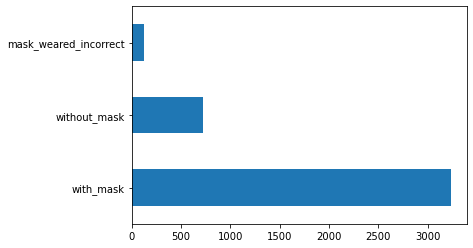

In [13]:
df["name"].value_counts().plot(kind='barh')
plt.show()

We've got an unbalanced dataset, so when we're splitting data into train and test we have to take this into consideration 

#### Let's rename some columns, files to filename and name to labels

In [14]:
df.columns

Index(['file', 'width', 'height', 'depth', 'name', 'xmin', 'ymin', 'xmax',
       'ymax'],
      dtype='object')

In [15]:
new = {'file':'filename','name':'label'}
df.rename(columns=new, inplace=True)
df.columns

Index(['filename', 'width', 'height', 'depth', 'label', 'xmin', 'ymin', 'xmax',
       'ymax'],
      dtype='object')

#### Prepare data
I'm going to split the data into test and train data and also create new folder for it.

In [16]:
labels = df.label.unique()
output_data_path = r'C:\Users\pc\Desktop\Machine_learning\face_mask\face_mask\images'
directory = ['train', 'test']

for i in labels:
    for d in directory:
        path = os.path.join(output_data_path,d,i)
        if not os.path.exists(path):
            os.makedirs(path)

As seen from the number of dataset we have compared to the images, it shows we've got multiple faces in some images. Now I'm going to use the coordinates given to crop the faces and split it into train and test

In [17]:
def crop_image(image_path, x_min, y_min, x_max, y_max):
    img = Image.open(image_path)
    cropped = img.crop((x_min, y_min, x_max, y_max))
    return cropped

In [18]:
def extract_faces(image_name, image_info):
    faces = []
    df_one_img = image_info[image_info['filename'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'label']]
    #print(df_one_img)
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_paths = os.path.join(image_path, image_name)
        faces.append((crop_image(image_paths, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [19]:
cropped_faces = [extract_faces(img, df) for img in images]
cropped_faces[:1]

[[(<PIL.Image.Image image mode=RGB size=30x37 at 0x1DB65826460>,
   'without_mask',
   'maksssksksss0_(79, 105)'),
  (<PIL.Image.Image image mode=RGB size=41x44 at 0x1DB65898D60>,
   'with_mask',
   'maksssksksss0_(185, 100)'),
  (<PIL.Image.Image image mode=RGB size=35x51 at 0x1DB65898AF0>,
   'without_mask',
   'maksssksksss0_(325, 90)')]]

In [20]:
# We've got our cropped face as a list of list so let's flatten it
flat_cropped_faces = sum(cropped_faces, [])
flat_cropped_faces[:1]

[(<PIL.Image.Image image mode=RGB size=30x37 at 0x1DB65826460>,
  'without_mask',
  'maksssksksss0_(79, 105)')]

Sort the images into their labels according to our 3 classes.

In [21]:
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

In [22]:
print(f'num of images with mask: {len(with_mask)}')
print(f'num of images without mask: {len(without_mask)}')
print(f'num of images incorrect mask: {len(mask_weared_incorrect)}')
print(f'sum: {len(with_mask) + len(without_mask) + len(mask_weared_incorrect) }')

num of images with mask: 3232
num of images without mask: 717
num of images incorrect mask: 123
sum: 4072


We now split into train and test. 80% for train and the rest for test

In [23]:
from sklearn.model_selection import train_test_split

train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=7)

train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=7)


train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=7)

In [24]:
def save_image(image, image_name, output_data_path,  dataset_type, label):
    '''
     This function takes an image name + a path of output folder
     and saves image into the output folder
    '''

    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path) 

In [25]:
# Train set


for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')
        
# Test set

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')

### Data augmentation

In [26]:
batch_size = 8
epochs = 50

In [27]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

test_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 

train_generator = datagen.flow_from_directory(
    directory=r'C:\Users\pc\Desktop\Machine_learning\face_mask\face_mask\images\train', 
    target_size = (64,64),
    class_mode="categorical", batch_size=batch_size, shuffle=True

)



# Test data
test_generator = test_datagen.flow_from_directory(
    directory=r'C:\Users\pc\Desktop\Machine_learning\face_mask\face_mask\images\test', 
    target_size = (64,64),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)

Found 3256 images belonging to 3 classes.
Found 816 images belonging to 3 classes.


In [28]:
data_size = len(train_generator) 


steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

test_steps = int(len(test_generator) // batch_size)
print(f"train_steps: {test_steps}")

steps_per_epoch: 50
train_steps: 12


#### Building model

I'm going to start by building my own model 

In [29]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (64,64,3)))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
model.add(MaxPooling2D(pool_size = 2))
model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(units = 500, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(units = 3, activation = 'softmax'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 8, 8, 64)         0

In [30]:
# Compiling the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    #metrics="accuracy"
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']

)

In [31]:
# Fit the model on train data

model_history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    #verbose=2,
    validation_data=test_generator,
    validation_steps=test_steps,

)

Epoch 1/50
50/50 [==============================] - 8s 101ms/step - loss: 0.6191 - accuracy: 0.7775 - recall: 0.7475 - precision: 0.7910 - auc: 0.8989 - val_loss: 1.2573 - val_accuracy: 0.7396 - val_recall: 0.7396 - val_precision: 0.7474 - val_auc: 0.7649
Epoch 2/50
50/50 [==============================] - 4s 78ms/step - loss: 0.3952 - accuracy: 0.8825 - recall: 0.8625 - precision: 0.8961 - auc: 0.9569 - val_loss: 0.8171 - val_accuracy: 0.7292 - val_recall: 0.7292 - val_precision: 0.7292 - val_auc: 0.9003
Epoch 3/50
50/50 [==============================] - 4s 81ms/step - loss: 0.2323 - accuracy: 0.9425 - recall: 0.9375 - precision: 0.9470 - auc: 0.9823 - val_loss: 1.2545 - val_accuracy: 0.7292 - val_recall: 0.7292 - val_precision: 0.7292 - val_auc: 0.8828
Epoch 4/50
50/50 [==============================] - 4s 80ms/step - loss: 0.2812 - accuracy: 0.9000 - recall: 0.8950 - precision: 0.9086 - auc: 0.9788 - val_loss: 0.9729 - val_accuracy: 0.7188 - val_recall: 0.7188 - val_precision: 0.72

50/50 [==============================] - 5s 96ms/step - loss: 0.1678 - accuracy: 0.9500 - recall: 0.9450 - precision: 0.9497 - auc: 0.9917 - val_loss: 0.6642 - val_accuracy: 0.7812 - val_recall: 0.7708 - val_precision: 0.7789 - val_auc: 0.9358
Epoch 34/50
50/50 [==============================] - 4s 81ms/step - loss: 0.2154 - accuracy: 0.9350 - recall: 0.9250 - precision: 0.9415 - auc: 0.9866 - val_loss: 0.9043 - val_accuracy: 0.7396 - val_recall: 0.7396 - val_precision: 0.7396 - val_auc: 0.9050
Epoch 35/50
50/50 [==============================] - 4s 88ms/step - loss: 0.1566 - accuracy: 0.9450 - recall: 0.9450 - precision: 0.9474 - auc: 0.9926 - val_loss: 0.7344 - val_accuracy: 0.7708 - val_recall: 0.7708 - val_precision: 0.7708 - val_auc: 0.9308
Epoch 36/50
50/50 [==============================] - 5s 92ms/step - loss: 0.2220 - accuracy: 0.9375 - recall: 0.9250 - precision: 0.9367 - auc: 0.9848 - val_loss: 0.6613 - val_accuracy: 0.7500 - val_recall: 0.7500 - val_precision: 0.7660 - val_

#### Model evaluation

In [32]:
# Evaluate model performance on test data
model_loss, model_acc, recall, precision, auc = model.evaluate(test_generator)
print("Model has a loss of %.2f and accuracy %.2f%%" % (model_loss, model_acc*100))
print("Model has a recall of %.2f%%, precision of %.2f%% and auc of %.2f%%" % (recall*100, precision*100, auc*100))

102/102 [==============================] - 2s 22ms/step - loss: 0.1998 - accuracy: 0.9424 - recall: 0.9363 - precision: 0.9467 - auc: 0.9876
Model has a loss of 0.20 and accuracy 94.24%
Model has a recall of 93.63%, precision of 94.67% and auc of 98.76%


In [33]:
predictions = model.predict(test_generator)
print("predictions shape:", predictions.shape)

102/102 [==============================] - 2s 20ms/step
predictions shape: (816, 3)


In [34]:
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

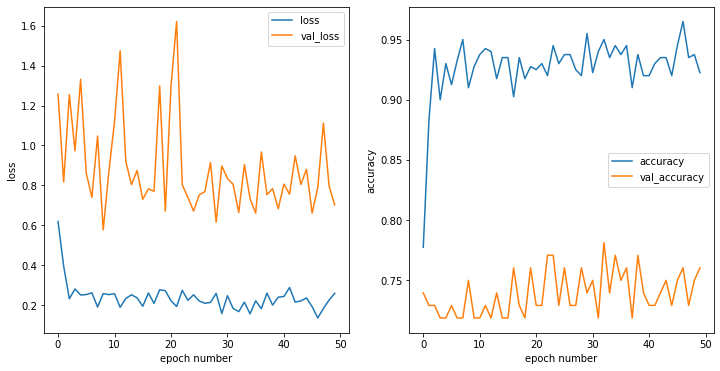

In [35]:
plot_loss_and_accuracy(model_history.history)

102/102 [==============================] - 2s 21ms/step
Class Predicted: with_mask , True label: with_mask


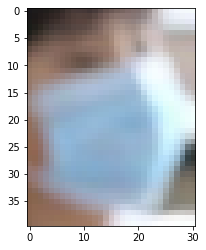

In [36]:
# predict a random face from our dataset

paths = test_generator.filenames # Your files path

y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices
classes = test_generator.class_indices  # Map of Indices to Class name

a_img_rand = np.random.randint(0,len(paths))   # A rand to pick a rand image
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # colored output image

#img = image.img_to_array(img)
plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0].split('\\')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'Class Predicted: {predicted_label} , True label: {true_label}')

#### Save model

In [37]:
model.save('face_mask_model.h5')

### Create a function to detect face in pictures
I'm going to make use of the opencv dnn caffe model

In [38]:
#loading model
modelFile =r"C:\Users\pc\Desktop\delete\caffe_model_for_dace_detection\res10_300x300_ssd_iter_140000.caffemodel"
configFile =r"C:\Users\pc\Desktop\delete\caffe_model_for_dace_detection\deploy.prototxt.txt"
net = cv2.dnn.readNetFromCaffe( configFile, modelFile)

In [39]:
def detect(net, path, min_confidence=0.3):
    image = cv2.imread(path)
    frame = image.copy()
    h, w, _ = image.shape
    blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300),
                mean=(104.0, 117.0, 123.0), swapRB=False, crop=False)
    net.setInput(blob)
    detections = net.forward()
    for i in np.arange(0, detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if confidence > min_confidence:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            text = "{:2f}%".format(confidence*100)
            y = startY - 10 if startX - 10 > 10 else startY+10
            cv2.rectangle(image, (startX,startY), (endX,endY),(0,0,255),2)
            cv2.putText(image, text, (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,0,255), 2)
    plt.figure(figsize=[20,20])
    plt.subplot(121);plt.imshow(frame[:,:,::-1]);plt.title("Original Image");plt.axis('off');
    plt.subplot(122);plt.imshow(image[:,:,::-1]);plt.title("Output");plt.axis('off');

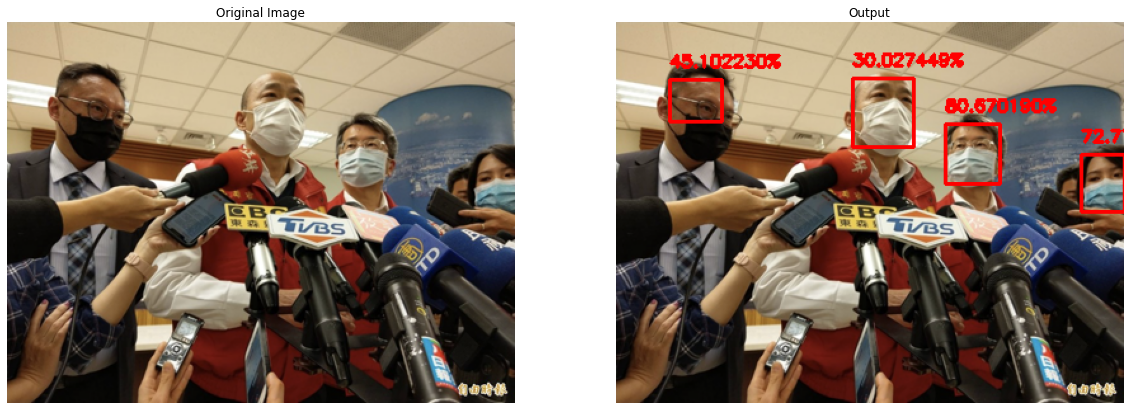

In [40]:
# showing prediction on image from our data
path = r'C:\Users\pc\Desktop\Machine_learning\face_mask\face_mask\images\maksssksksss103.png'
detect(net=net, path=path)

1/1 [==============================] - 0s 29ms/step


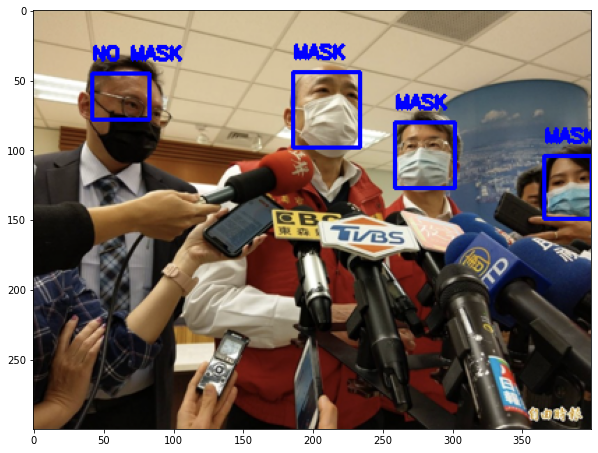

In [41]:
# Making prediction to detect mask

def predict(net, path, min_confidence=0.3):
    image = cv2.imread(path)
    image_crop = Image.open(path) #pil
    colored_img = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)  # colored output image # to show original image
    mask_label = {0:'MASK INCORRECT',1:'MASK', 2:'NO MASK'}
    color_label = {0:(0,255,255),1:(0, 255,0), 2:(255,0,0)}
    def extract_face():
        h, w, _ = image.shape
        blob = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300),
                    mean=(104.0, 117.0, 123.0), swapRB=False, crop=False)
        net.setInput(blob)
        detections = net.forward() 
        count = 0
        for i in np.arange(0, detections.shape[2]):
            confidence = detections[0, 0, i, 2]
            if confidence > min_confidence:
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")
                
                text = "{:2f}%".format(confidence*100)
                y = startY - 10 if startX - 10 > 10 else startY+10
                face = image_crop.crop((startX, startY, (endX), (endY)))
                resized_face = cv2.resize(np.array(face),(64,64))
                resized_face = resized_face[:, :, :3]
                reshaped_face = np.reshape(resized_face,[1,64,64,3])/255.0
                face_result = model.predict(reshaped_face)
                cv2.rectangle(colored_img, (startX,startY), (endX,endY),(0,0,255),2)
                cv2.putText(colored_img, mask_label[face_result.argmax()], (startX, y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0,0,255), 2)

    extract_face()
    plt.figure(figsize=(10, 10))    
    plt.imshow(colored_img)
predict(net=net, path=path)

#### Suggestions to improve model
* Collect more images of people wearing the mask incorrectly, since although in reality Wearing a mask incorrectly is like not wearing a mask at all, the model classifies it as wearing a mask.

* Use transfer learning with a pretrained model.